In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

x, y = make_circles(n_samples, noise = 0.03, random_state = 42) 

In [3]:
print(f"First five sample of x:\n{x[:5]}")
print(f"First five sample of y:\n{y[:5]}")

First five sample of x:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five sample of y:
[1 1 1 1 0]


In [4]:
circles = pd.DataFrame({"X1": x[:,0], 
                        "X2": x[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

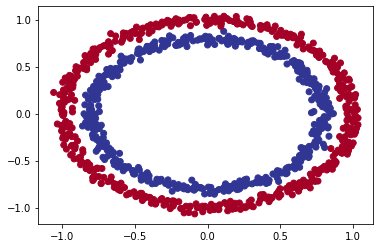

In [6]:
plt.scatter(circles['X1'], circles['X2'], c = circles['label'], cmap = plt.cm.RdYlBu)

In [7]:
x.shape, y.shape

((1000, 2), (1000,))

In [8]:
x_sample = x[0]
y_sample = y[0]
print(f"Value of one sample of x: {x_sample} and value of sample of y: {y_sample}")
print(f"Value of one sample shape of x: {x_sample.shape} and value of sample shape of y: {y_sample.shape}")

Value of one sample of x: [0.75424625 0.23148074] and value of sample of y: 1
Value of one sample shape of x: (2,) and value of sample shape of y: ()


In [9]:
# convert numpy to tensor
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(x), type(y)

(torch.Tensor, torch.Tensor)

In [10]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 64)

len(x_train), len(y_train), len(x_test), len(y_test)

(750, 750, 250, 250)

In [11]:
# decide device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
# build model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # creater layers
    self.layer1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer2 = nn.Linear(in_features = 5, out_features = 1)

  # forward method
  def foeward(self, x):
    return self.layer2(self.layer1(x))


model_0 = CircleModelV0()
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0.state_dict()

OrderedDict([('layer1.weight', tensor([[ 0.4224, -0.1270],
                      [ 0.6560, -0.5392],
                      [ 0.0376,  0.4897],
                      [ 0.2208,  0.1312],
                      [-0.4578,  0.2833]])),
             ('layer1.bias',
              tensor([-0.2198,  0.0265, -0.6915,  0.4510, -0.2952])),
             ('layer2.weight',
              tensor([[-0.3200,  0.4080, -0.1273, -0.2828,  0.3864]])),
             ('layer2.bias', tensor([-0.0131]))])

In [14]:
model_0 = model_0.to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [15]:
# create model using sequential
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.4295, -0.3211],
                      [ 0.4380,  0.0453],
                      [-0.6934,  0.5429],
                      [ 0.0027,  0.3436],
                      [ 0.5394,  0.3954]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.5334, -0.5376,  0.3018,  0.1721, -0.6907], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2805, -0.2191,  0.2349, -0.2331,  0.3301]], device='cuda:0')),
             ('1.bias', tensor([-0.3971], device='cuda:0'))])

In [17]:
# predict with out train
with torch.inference_mode():
  without_train_pred = model_0(x_test.to(device))

print(f"predict len: {len(without_train_pred)}, shape: {without_train_pred.shape}")
print(f"test label len: {len(y_test)}, shape: {y_test.shape}")
print(f"smaple value pred: {without_train_pred[:10]}, label: {y_test[:10]}")

predict len: 250, shape: torch.Size([250, 1])
test label len: 250, shape: torch.Size([250])
smaple value pred: tensor([[-0.6273],
        [-0.8359],
        [-0.5709],
        [-0.8440],
        [-0.5209],
        [-0.7254],
        [-0.3669],
        [-0.8337],
        [-0.8608],
        [-0.6962]], device='cuda:0'), label: tensor([1., 1., 0., 0., 1., 0., 0., 1., 0., 1.])


In [18]:
# loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)



In [19]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [20]:
# train model
# view first five o/p in first forward pass
y_logi = model_0(x_test.to(device))[:5]
y_logi

tensor([[-0.6273],
        [-0.8359],
        [-0.5709],
        [-0.8440],
        [-0.5209]], device='cuda:0', grad_fn=<SliceBackward0>)

In [21]:
y_pred_prob = torch.sigmoid(y_logi)
y_pred_prob

tensor([[0.3481],
        [0.3024],
        [0.3610],
        [0.3007],
        [0.3726]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [22]:
# find prediction labels
y_preds = torch.round(y_pred_prob)

y_pred_labels = torch.round(torch.sigmoid(model_0(x_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
y_test[:5]

tensor([1., 1., 0., 0., 1.])

In [24]:
torch.manual_seed(42)

epoches = 500

ep_list = []
ls_list = []
tl_list = []

for epoch in range(epoches):
  # train model
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(x_train.to(device)).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. loss
  loss = loss_fn(y_logits, y_train.to(device))
  acc = accuracy_fn(y_true = y_train.to(device), y_pred = y_pred)

  # 3. zero optimizer
  optimizer.zero_grad()

  # 4. backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  # test
  model_0.eval()

  with torch.inference_mode():
    # 1. forward
    test_logits = model_0(x_test.to(device)).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

  # 2. loss
  test_loss = loss_fn(test_logits, y_test.to(device))
  test_acc = accuracy_fn(y_true = y_test.to(device), y_pred = test_pred)

  if epoch % 50 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Train accuracy: {acc:.2f} |Test Loss: {test_loss:.4f} | Test accuaey: {test_acc:.2f}")

  ep_list.append(epoch)
  ls_list.append(loss)
  tl_list.append(test_loss)



Epoch: 0 | Loss: 0.7465 | Train accuracy: 50.00 |Test Loss: 0.7382 | Test accuaey: 50.00
Epoch: 50 | Loss: 0.7233 | Train accuracy: 50.00 |Test Loss: 0.7167 | Test accuaey: 50.00
Epoch: 100 | Loss: 0.7110 | Train accuracy: 50.00 |Test Loss: 0.7056 | Test accuaey: 50.00
Epoch: 150 | Loss: 0.7045 | Train accuracy: 50.00 |Test Loss: 0.6997 | Test accuaey: 50.00
Epoch: 200 | Loss: 0.7009 | Train accuracy: 43.47 |Test Loss: 0.6966 | Test accuaey: 40.00
Epoch: 250 | Loss: 0.6989 | Train accuracy: 44.80 |Test Loss: 0.6950 | Test accuaey: 47.60
Epoch: 300 | Loss: 0.6977 | Train accuracy: 47.07 |Test Loss: 0.6941 | Test accuaey: 48.80
Epoch: 350 | Loss: 0.6969 | Train accuracy: 47.60 |Test Loss: 0.6936 | Test accuaey: 48.80
Epoch: 400 | Loss: 0.6963 | Train accuracy: 47.73 |Test Loss: 0.6933 | Test accuaey: 48.40
Epoch: 450 | Loss: 0.6959 | Train accuracy: 48.53 |Test Loss: 0.6931 | Test accuaey: 49.20


In [25]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("file exists, skip download")
else:
  print("Download file")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download file


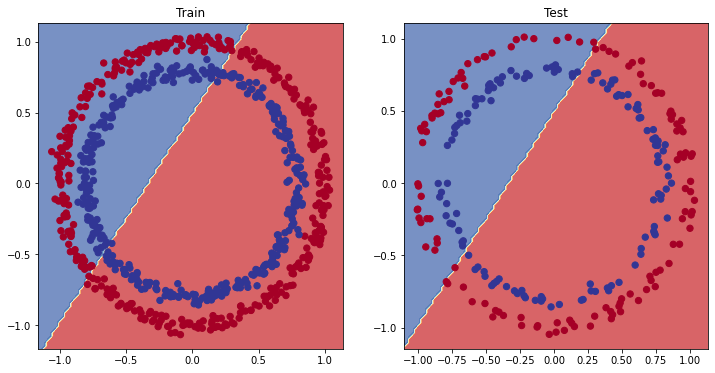

In [26]:
# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

# train second better model with (improve  previous one)

In [27]:
# model 1
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

In [29]:
# train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoches = 1000

ep_list = []
ls_list = []
tl_list = []

# train
for epoch in range(epoches):
  model_1.train()

  # 1. forward
  y_logits = model_1(x_train.to(device)).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. loss
  loss = loss_fn(y_logits, y_train.to(device))
  acc = accuracy_fn(y_train.to(device), y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. backward
  loss.backward()

  # 5.optimizer zero step
  optimizer.step()

  # test
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward
    test_logits = model_1(x_test.to(device)).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

  # 2 loss
  test_loss = loss_fn(test_logits, y_test.to(device))
  test_acc = accuracy_fn(y_test.to(device), test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Train accuracy: {acc:.2f} |Test Loss: {test_loss:.4f} | Test accuaey: {test_acc:.2f}")

  ep_list.append(epoch)
  ls_list.append(loss)
  tl_list.append(test_loss)  

Epoch: 0 | Loss: 0.6937 | Train accuracy: 50.53 |Test Loss: 0.6935 | Test accuaey: 52.00
Epoch: 100 | Loss: 0.6935 | Train accuracy: 50.27 |Test Loss: 0.6935 | Test accuaey: 50.80
Epoch: 200 | Loss: 0.6934 | Train accuracy: 50.27 |Test Loss: 0.6935 | Test accuaey: 49.60
Epoch: 300 | Loss: 0.6933 | Train accuracy: 50.00 |Test Loss: 0.6936 | Test accuaey: 49.60
Epoch: 400 | Loss: 0.6932 | Train accuracy: 50.13 |Test Loss: 0.6936 | Test accuaey: 50.00
Epoch: 500 | Loss: 0.6931 | Train accuracy: 50.67 |Test Loss: 0.6937 | Test accuaey: 48.40
Epoch: 600 | Loss: 0.6931 | Train accuracy: 51.07 |Test Loss: 0.6937 | Test accuaey: 46.00
Epoch: 700 | Loss: 0.6931 | Train accuracy: 50.80 |Test Loss: 0.6938 | Test accuaey: 46.00
Epoch: 800 | Loss: 0.6931 | Train accuracy: 51.47 |Test Loss: 0.6938 | Test accuaey: 45.20
Epoch: 900 | Loss: 0.6930 | Train accuracy: 51.07 |Test Loss: 0.6939 | Test accuaey: 45.60


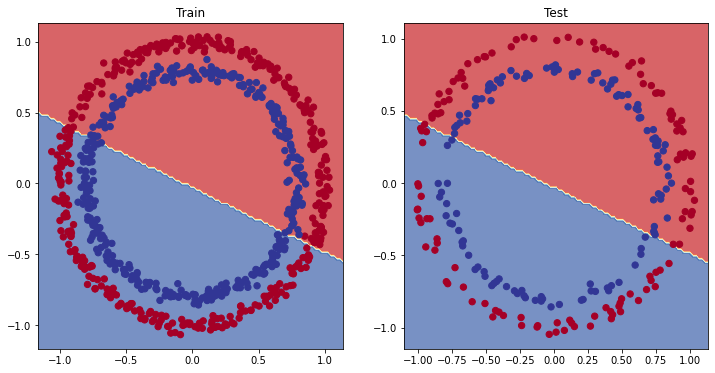

In [30]:
# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, x_test, y_test)

In [31]:
# check model learn something or not
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

x = torch.arange(start, end, step)
y = weight*x + bias

x_trn, x_tt, y_trn, y_tt =  train_test_split(x, y, test_size = 0.25, random_state = 0)
# x_trn , y_trn = x_trn.to(device), y_trn.to(device)
# x_tt , y_tt = x_tt.to(device), y_tt.to(device)

len(x_trn), len(y_trn), len(x_tt), len(y_tt)

(75, 75, 25, 25)

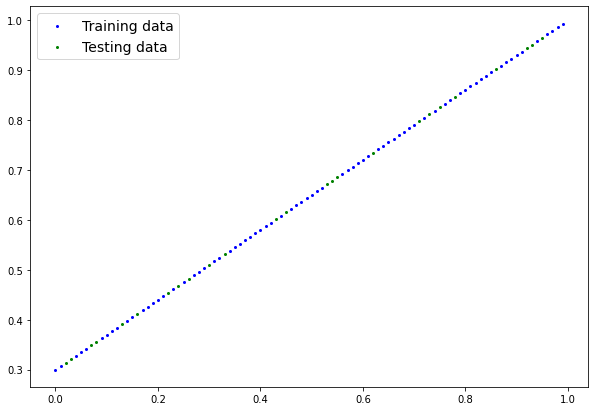

In [32]:
plot_predictions(x_trn, y_trn, x_tt, y_tt)

In [33]:
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
# loss
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)

In [35]:
# train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoches = 1000

ep_list = []
ls_list = []
tl_list = []

# train
for epoch in range(epoches):
  model_2.train()

  # 1. forward
  y_pred = model_2(x_trn.reshape(len(x_trn), 1)).squeeze()
  

  # 2. loss
  loss = loss_fn(y_pred, y_trn)


  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. backward
  loss.backward()

  # 5.optimizer zero step
  optimizer.step()

  # test
  model_2.eval()
  with torch.inference_mode():
    # 1. Forward
    test_pred = model_2(x_tt.reshape(len(x_tt), 1)).squeeze()

    # 2 loss
    test_loss = loss_fn(test_pred, y_tt)


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

  ep_list.append(epoch)
  ls_list.append(loss)
  tl_list.append(test_loss)  

Epoch: 0 | Loss: 0.8027 | Test Loss: 0.7465
Epoch: 100 | Loss: 0.0253 | Test Loss: 0.0160
Epoch: 200 | Loss: 0.0229 | Test Loss: 0.0159
Epoch: 300 | Loss: 0.0245 | Test Loss: 0.0148
Epoch: 400 | Loss: 0.0243 | Test Loss: 0.0141
Epoch: 500 | Loss: 0.0231 | Test Loss: 0.0144
Epoch: 600 | Loss: 0.0219 | Test Loss: 0.0148
Epoch: 700 | Loss: 0.0215 | Test Loss: 0.0143
Epoch: 800 | Loss: 0.0213 | Test Loss: 0.0138
Epoch: 900 | Loss: 0.0213 | Test Loss: 0.0131


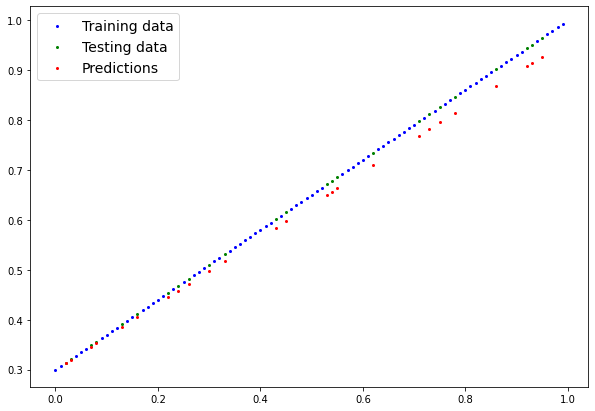

In [36]:
plot_predictions(x_trn, y_trn, x_tt, y_tt, predictions = test_pred)

#  Create non-linear model

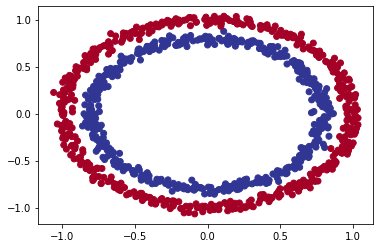

In [37]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

n_samples = 1000

x, y = make_circles(n_samples = n_samples, noise = 0.03, random_state = 42)

plt.scatter(x[:,0], x[:,1], c = y, cmap = plt.cm.RdYlBu)

In [38]:
import torch
from sklearn.model_selection import train_test_split

# numpy to torch
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split into train test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)


In [39]:
# bulid non-linear model
from torch import nn

class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)
model_3

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
# loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_3.parameters(), lr = 0.1)

In [41]:
# train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoches = 10000

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epoches):
  # train
  model_3.train()

  # 1. Forward
  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2.loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. optimize zero grad
  optimizer.zero_grad()

  # 4. backward
  loss.backward()

  # 5. optimze step
  optimizer.step()

  # test
  model_3.eval()

  with torch.inference_mode():
    # 1. forward
    test_logits = model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_acc = accuracy_fn(y_test, test_pred)

    # 2. loss
    test_loss = loss_fn(test_logits, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | acc: {acc:.2f} | Test Loss: {test_loss:.4f} | accuracy_fn: {test_acc:.2f}")

Epoch: 0 | Loss: 0.6929 | acc: 50.53 | Test Loss: 0.6934 | accuracy_fn: 48.40
Epoch: 100 | Loss: 0.6912 | acc: 65.47 | Test Loss: 0.6913 | accuracy_fn: 63.60
Epoch: 200 | Loss: 0.6898 | acc: 67.87 | Test Loss: 0.6897 | accuracy_fn: 68.00
Epoch: 300 | Loss: 0.6879 | acc: 57.47 | Test Loss: 0.6877 | accuracy_fn: 60.40
Epoch: 400 | Loss: 0.6852 | acc: 55.20 | Test Loss: 0.6848 | accuracy_fn: 57.60
Epoch: 500 | Loss: 0.6813 | acc: 54.93 | Test Loss: 0.6807 | accuracy_fn: 57.60
Epoch: 600 | Loss: 0.6750 | acc: 56.27 | Test Loss: 0.6747 | accuracy_fn: 58.00
Epoch: 700 | Loss: 0.6664 | acc: 60.80 | Test Loss: 0.6662 | accuracy_fn: 59.20
Epoch: 800 | Loss: 0.6522 | acc: 65.07 | Test Loss: 0.6526 | accuracy_fn: 68.00
Epoch: 900 | Loss: 0.6241 | acc: 74.27 | Test Loss: 0.6280 | accuracy_fn: 75.20
Epoch: 1000 | Loss: 0.5698 | acc: 86.00 | Test Loss: 0.5802 | accuracy_fn: 84.40
Epoch: 1100 | Loss: 0.4858 | acc: 92.67 | Test Loss: 0.5052 | accuracy_fn: 88.00
Epoch: 1200 | Loss: 0.3778 | acc: 97.07 

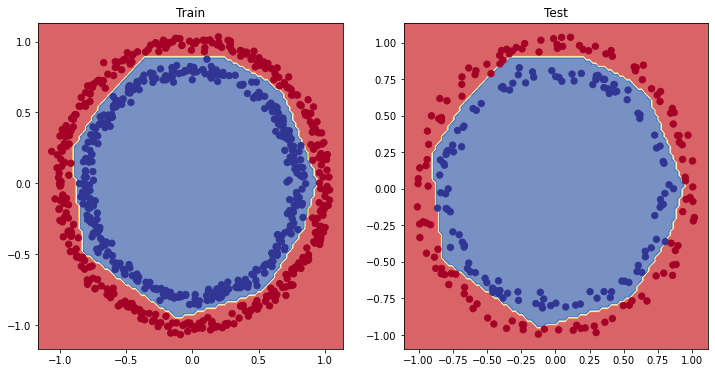

In [42]:
# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, x_train.cpu(), y_train.cpu())
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, x_test.cpu(), y_test.cpu())

# Multiclass clasification

In [70]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

NUMBER_OF_CLASSES = 4
NUMBER_OF_IN_FEATURE = 2
RANDOM_SEED = 42

x_blob, y_blob = make_blobs(n_samples = 1000, n_features = NUMBER_OF_IN_FEATURE, 
                            centers = NUMBER_OF_CLASSES, cluster_std = 1.5, 
                            random_state = RANDOM_SEED)

x_blob[:5], y_blob[:5]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]), array([3, 2, 2, 1, 1]))

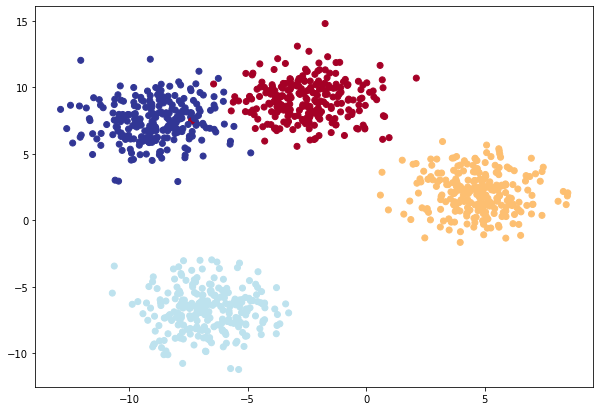

In [71]:
plt.figure(figsize=((10,7)))
plt.scatter(x_blob[:,0], x_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [72]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [85]:
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, test_size=0.25, random_state = RANDOM_SEED)

x_blob_train, y_blob_train = x_blob_train.to(device), y_blob_train.to(device)
x_blob_test, y_blob_test = x_blob_test.to(device), y_blob_test.to(device)



TypeError: ignored

In [86]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_features):
    super().__init__()

    self.blob_network = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_features),
        # nn.ReLU(),
        nn.Linear(in_features = hidden_features, out_features = hidden_features),
        # nn.ReLU(),
        nn.Linear(in_features = hidden_features, out_features = output_features)
    )

  def forward(self, x):
    return self.blob_network(x)


model_blob = BlobModel(NUMBER_OF_IN_FEATURE, NUMBER_OF_CLASSES, 8).to(device)
model_blob


BlobModel(
  (blob_network): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [87]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_blob.parameters(), lr = 0.1)

In [88]:
# predict with out training
model_blob(x_blob_train)[:5]

tensor([[ 0.6343, -1.4571,  0.5101,  1.4156],
        [ 0.5940, -1.3622,  0.4794,  1.3122],
        [ 2.9613,  0.6365,  3.3778,  1.6846],
        [ 0.1179, -1.4442, -0.0573,  0.9962],
        [-0.7028, -0.6302, -0.8447, -0.2680]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [89]:
logits = model_blob(x_blob_test)
pred = torch.softmax(logits, dim=1)
pred[:5]

tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [90]:
type(logits.type(torch.float))
y_blob_train

tensor([0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2, 3, 1,
        1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1, 3, 1,
        2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 0, 2, 0, 3, 2, 0, 0,
        2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2, 3, 0,
        0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 3, 0, 2, 0, 1, 2, 2,
        2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2, 2, 2,
        2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3, 1, 0,
        0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2, 0, 2,
        0, 3, 1, 3, 0, 2, 2, 0, 1, 1, 0, 2, 1, 1, 1, 0, 1, 3, 1, 1, 0, 2, 2, 3,
        1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 1, 0, 2, 2,
        2, 2, 3, 1, 2, 2, 0, 2, 3, 3, 1, 3, 3, 1, 2, 1, 1, 1, 1, 0, 2, 1, 0, 2,
        3, 2, 2, 3, 2, 3, 2, 0, 3, 3, 0, 0, 3, 0, 2, 1, 0, 1, 0, 2, 1, 3, 2, 3,
        1, 1, 0, 0, 3, 2, 3, 2, 2, 1, 3,

In [91]:
torch.sum(pred[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [92]:
print(pred[0])
print(torch.argmax(pred[0]))
print(y_blob_train[0])

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')


In [93]:
torch.argmax(pred, dim=1)

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3, 1, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2,
        1, 1, 3, 2, 2, 2, 3, 1, 3, 2, 3, 3, 1, 3, 3, 1, 1, 3, 3, 2, 2, 3, 3, 3,
        1, 1, 2, 3, 3, 3, 3, 3, 1, 3], device='cuda:0')

In [94]:
# train model
epoches = 1000

torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(epoches):
  # train
  model_blob.train()

  # 1. Forward 
  y_blob_logits = model_blob(x_blob_train)
  y_blob_pred = torch.softmax(y_blob_logits, dim = 1).argmax(dim=1)

  # 2. loss
  loss = loss_fn(y_blob_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_blob_pred)

  # 3. optimizer zero step
  optimizer.zero_grad()

  # 4. backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  # test
  model_blob.eval()
  with torch.inference_mode():
    # 1. forward
    test_blob_logits = model_blob(x_blob_test)
    test_blob_pred = torch.argmax(torch.softmax(test_blob_logits, dim =1), dim = 1)

    # 2. loss
    test_loss = loss_fn(test_blob_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_blob_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test loss: {test_loss:.4f} | Acc: {acc} | Test Acc: {test_acc}")

Epoch: 0 | Loss: 1.0426 | Test loss: 0.5734 | Acc: 65.60000000000001 | Test Acc: 96.8
Epoch: 100 | Loss: 0.0328 | Test loss: 0.0221 | Acc: 99.06666666666666 | Test Acc: 99.6
Epoch: 200 | Loss: 0.0281 | Test loss: 0.0162 | Acc: 99.06666666666666 | Test Acc: 99.6
Epoch: 300 | Loss: 0.0267 | Test loss: 0.0142 | Acc: 99.06666666666666 | Test Acc: 99.6
Epoch: 400 | Loss: 0.0260 | Test loss: 0.0131 | Acc: 99.06666666666666 | Test Acc: 99.6
Epoch: 500 | Loss: 0.0255 | Test loss: 0.0125 | Acc: 99.06666666666666 | Test Acc: 99.6
Epoch: 600 | Loss: 0.0251 | Test loss: 0.0120 | Acc: 99.06666666666666 | Test Acc: 99.6
Epoch: 700 | Loss: 0.0248 | Test loss: 0.0116 | Acc: 99.2 | Test Acc: 99.6
Epoch: 800 | Loss: 0.0245 | Test loss: 0.0113 | Acc: 99.2 | Test Acc: 99.6
Epoch: 900 | Loss: 0.0243 | Test loss: 0.0110 | Acc: 99.33333333333333 | Test Acc: 99.6


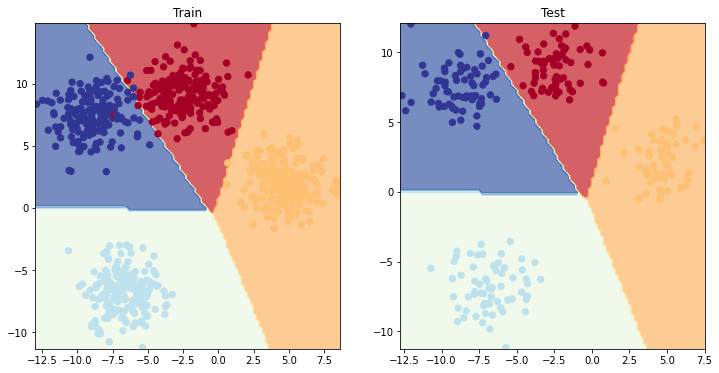

In [98]:
# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_blob, x_blob_train.cpu(), y_blob_train.cpu())
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_blob, x_blob_test.cpu(), y_blob_test.cpu())